In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import random
import json
import statsmodels.graphics.tsaplots as tsaplots
import pymc as pm
from scipy.misc import factorial

In [2]:
# from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests
from datetime import datetime
from dateutil import parser
from collections import Counter
from itertools import groupby

In [38]:
movies_reviewed = {}

try:
    page=requests.get("http://www.rottentomatoes.com/user/id/780849123/ratings")
    soup = BeautifulSoup(page.text, "html.parser")

    page_reviews = soup.find_all("div", attrs={"class":"panel-body content_body"})
    movie = page_reviews[3].find_all("div", attrs={"class":"media-body"})
    num_movie = 0
    for m in movie:
        #Check get the number of stars
        stars = m.find_all("span", attrs ={"class":"glyphicon glyphicon-star"})
        movie_page = requests.get("http://www.rottentomatoes.com/" + m.find("div", attrs={"class":"media-heading"}).find("a").get("href"))
        soup = BeautifulSoup(movie_page.text, "html.parser")
        genres = soup.find_all("span", attrs={"itemprop":"genre"})
        for g in genres:
            if g.get_text() not in movies_reviewed.keys():
                movies_reviewed[g.get_text()] = len(stars)
            else:
                movies_reviewed[g.get_text()] = np.hstack((movies_reviewed[g.get_text()], len(stars)))
        num_movie += 1
    
        if num_movie % 100 == 0:
            print num_movie
        
        if num_movie >= 300:
            break
        
except Exception as e:
    print "Exception"

100
200
300


In [50]:
data_save = {}
for k in movies_reviewed:
    data_save[k] = list(movies_reviewed[k])

In [53]:
with open('one_user_data.json', 'w') as fp:
    json.dump(data_save,fp)

In [3]:
with open('one_user_data.json') as data_file: 
    all_genres = json.load(data_file)

In [8]:
## Defining variables for convenience

dict_keys = all_genres.keys()
numgenres = len(dict_keys)
print 'total number of genres:', numgenres

rating_dist = np.zeros((numgenres,6))
nummoviesrated = np.zeros(numgenres)
for movieindx in np.arange(numgenres):
    rating_dist[movieindx,:] = np.bincount(all_genres[dict_keys[movieindx]],minlength=6)
    nummoviesrated[movieindx] = sum(rating_dist[movieindx,:])
print 'number of movies rated in each genre:',nummoviesrated

total number of genres: 17
number of movies rated in each genre: [  15.    3.    6.   92.   64.   13.   94.   50.    7.    2.  134.   23.
   14.    3.    6.   85.    2.]


## Multinomial distribution as Likelihood function

Since the ratings given by user are discrete with 6 different categories, we can use a multinomial likelihood function for this problem.

Let $x_i$ be the number of movies rated $i \in 0,1,...,5$, with $\sum_{i=0}^{5} x_i = n$. The probability of observing any set of ${x_i}$ is given by:

$$ P(x_0,x_1,...,x_5 \vert p_0,p_1,...,p_5) = \frac{n!}{x_0!x_1!...x_5!} \prod_{i=0}^{5} p_i^{x_i}$$,

where $p_i$ represent the probability of rating a movie with value $i$ and $\sum_{i=0}^{5} p_i = 1$. 

Using a Dirchlet conjugate prior with hyperparameters $\alpha_0,\alpha_1,...,\alpha_5$, the posterior distribution becomes:

$$ P(p_0,p_1,...,p_5 \vert x_0,x_1,...,x_5) \propto \prod_{i=0}^{5} p_i^{x_i+\alpha_i-1}$$

Below, we will use a value of 1 for all the $\alpha$ hyperparameters since we assume that we have no prior information of the preference of the user. 

Since all the probabilities must sum to 1 for each sample drawn from the posterior, the conditional distributions can be written as:

$$ P(p_0 \vert p_1,...p_5,x_0,...x_5) \propto p_0^{x_0+\alpha_0-1} (1-p_0-p_1-p_2-p_3-p_4)^{x_5+\alpha_5-1} $$

We can either use Gibbs sampling or MH to sample from the posterior. 

Using the samples from this posterior, we will then be able to reconstruct the distribution of the ratings using the posterior predictive likelihood, and use this rank the different movie genres.

In [9]:
## Define likelihood
Multinomial = lambda p,x: factorial(sum(x))/np.prod(factorial(x))*np.prod(p**x)

## Define hyperparameters of Dirichlet
alphavec = np.ones(6)

## Define log-posterior (neglect constants)
def logposteriormultinomial(pvec,x):
    logpost = 0
    for ii in range(5):
        logpost += (x[ii]+alphavec[ii]-1.0)*np.log(pvec[ii])
    logpost += (x[5]+alphavec[5]-1.0)*np.log(1.0-np.sum(pvec[0:5]))
    return logpost

In [14]:
rnorm = np.random.normal
runif = np.random.rand

def metropolisMultinomial(dataarray, n_iterations, initial_values, prop_std, doPrint=True):
    #################################################################
    # function to sample using Metropolis 
    # (assumes proposal distribution is symmetric)
    # dataarray: distribution of ratings
    # n_iterations:  number of iterations
    # initial_values: Initial guess of parameter value
    # prop_std: standard deviation for Gaussian proposal distribution 
    ##################################################################
    
    n_params = len(initial_values)
    
    # proposal standard deviations
    prop_sd = prop_std
            
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate log-posterior for initial values
    current_logprob = logposteriormultinomial(trace[0],dataarray)
    
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
#        if not i%10000 and doPrint: 
  #          print 'Iterations left: ', n_iterations-i
    
        # Grab current parameter values
        current_params = trace[i]
    
        # Get current value for parameter j
        p = trace[i].copy() 
        
        # loop over all dimensions
        for j in range(n_params):
            # proposed new value
            theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate posterior with proposed value
            proposed_logprob = logposteriormultinomial(p,dataarray)
    
            # Log-acceptance rate
            alpha = proposed_logprob-current_logprob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha and np.sum(p)<=1:
                # Accept
                trace[i+1,j] = theta
                current_logprob = proposed_logprob
                accepted[j] += 1
            else:
                # Stay put
                trace[i+1,j] = trace[i,j]
            
            # update p so we search the next dimension according
            # to the current result
            p[j] = trace[i+1,j]
    
    # return our samples and the number of accepted steps
    return trace, accepted

In [11]:
## Check acceptance ratios
n_iter = 500
meanaccratios = np.zeros((numgenres,5))
proposal_std = np.zeros((numgenres,5))
proposal_std[0] = np.ones(5)*0.1
proposal_std[1] = np.ones(5)*0.24
proposal_std[2] = np.ones(5)*0.18
proposal_std[3] = [0.025,0.04,0.04,0.04,0.04]
proposal_std[4] = [0.03,0.05,0.07,0.07,0.07]
proposal_std[5] = np.ones(5)*0.09
proposal_std[6] = np.ones(5)*0.04
proposal_std[7] = np.ones(5)*0.04
proposal_std[8] = np.ones(5)*0.16
proposal_std[9] = np.ones(5)*0.26
proposal_std[10] = [0.015,0.04,0.04,0.04,0.04]
proposal_std[11] = [0.07,0.12,0.14,0.14,0.07]
proposal_std[12] =  [0.1,0.1,0.19,0.19,0.1]
proposal_std[13] = [0.22,0.22,0.22,0.22,0.22]
proposal_std[14] = [0.18,0.18,0.18,0.3,0.3]
proposal_std[15] = [0.025,0.048,0.08,0.08,0.065]
proposal_std[16] = np.ones(5)*0.26
t_start = time.time()
for genreindx in range(numgenres):
    acc_ratios = []
    for i in range(500):
        start_pvec = sp.stats.dirichlet.rvs(alphavec)
        trace, acc = metropolisMultinomial(rating_dist[genreindx],n_iter,start_pvec[0][0:5], proposal_std[genreindx], doPrint=False) 
        acc_ratios.append(acc/np.double(n_iter))
    meanaccratios[genreindx] = np.mean(acc_ratios, axis=0)
    
timetaken = time.time() - t_start
print "time taken:", timetaken
print "max mean acceptance ratios",np.max(meanaccratios)
print "min mean acceptance ratios",np.min(meanaccratios)
## for plotting histograms of acceptance ratio
# acc_ratios = np.array(acc_ratios)
# plt.hist(acc_ratios)
# plt.xlabel("theta acceptance ratio")

time taken: 637.062999964
max mean acceptance ratios 0.3923
min mean acceptance ratios 0.3025


In [17]:
## Carry out MH for all movie genres and save the sample traces
n_iter = 100000
initpvec = sp.stats.dirichlet.rvs(alphavec)
print "Initial guess for parameters: ", [initpvec]

alltraces = np.zeros((n_iter+1,6,numgenres))
accratios = np.zeros((numgenres,5))

t_start = time.time()

for genreindx in range(numgenres):
    trace, acc = metropolisMultinomial(rating_dist[genreindx],n_iter, initpvec[0][0:5], proposal_std[genreindx])
    alltraces[:,0:5,genreindx] = trace
    alltraces[:,5,genreindx] = 1-np.sum(trace,1)
    accratios[genreindx] = acc/np.double(n_iter)

    timetaken = time.time() - t_start
    print "current genre:", genreindx
    print "time taken:", timetaken


Initial guess for parameters:  [array([[ 0.01184137,  0.18896014,  0.41731306,  0.03914294,  0.29857734,
         0.04416515]])]
current genre: 0
time taken: 17.6690001488
current genre: 1
time taken: 36.498000145
current genre: 2
time taken: 55.1840000153
current genre: 3
time taken: 74.2369999886
current genre: 4
time taken: 96.353000164
current genre: 5
time taken: 116.845000029
current genre: 6
time taken: 139.170000076
current genre: 7
time taken: 159.072999954
current genre: 8
time taken: 179.117000103
current genre: 9
time taken: 199.442000151
current genre: 10
time taken: 218.567000151
current genre: 11
time taken: 236.080000162
current genre: 12
time taken: 252.993999958
current genre: 13
time taken: 269.957000017
current genre: 14
time taken: 289.338999987
current genre: 15
time taken: 309.898000002
current genre: 16
time taken: 329.549999952


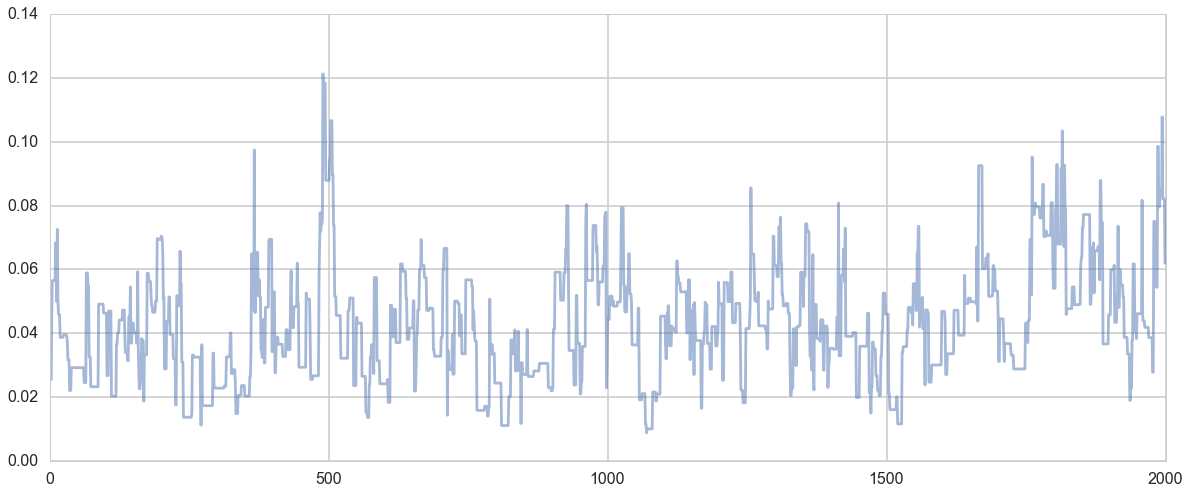

In [91]:
## Check convergence (plot time traces)
plt.figure(figsize=[20,8])
plt.plot(alltraces[-2000:,1,10], alpha=0.5)

In [49]:
# Functin to calculate correlation coefficient between the first t elements 
# and the last t elements of x.
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# function to calculate z-score of Geweke test
def Geweke(trace, intervals, length):
    nsl=length
    # number of samples between subtraces of consecutive intervals
    jump = int(0.9*len(trace)/(2*intervals))
    # Index of first sample to consider in trace ie allow for burnin
    first = 0.1*len(trace)
    
    z =np.empty(intervals)
    # Loop over the number of intervals
    for k in np.arange(0, intervals):
        # Initial sample of first sub-trace
        baga = np.int(first+k*jump)
        # Initial sample of second sub-trace
        bagb = len(trace)/2 + k*jump
        
        # Select two subtraces to compare between, each of length nsl
        sub_trace_a = trace[baga:baga+nsl]
        sub_trace_b = trace[bagb:bagb+nsl]
        
        # Calculate mean parameter values from the two subtraces
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        # Calculate integral of autocorrelation function
        # used to calculate effective sample size 
        for i in xrange(int(0.1*nsl)):
            # Calculate correlation between first (i+1) and last(i+1) elements 
            # in subtraces
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # Calculate variance of the mean of the twosubtraces, 
        # taking into account effective sample size
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        # calculate z-score. This uses the two-sample t-test of means. 
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z


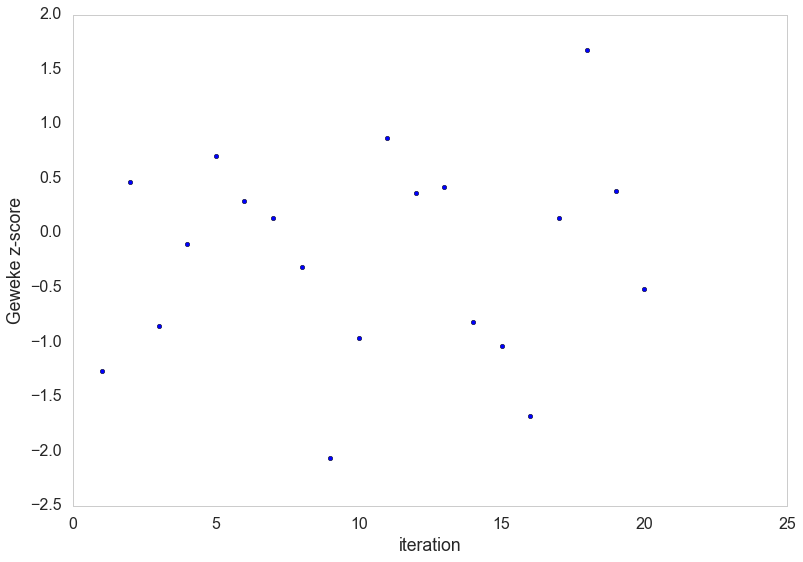

In [92]:
intervals = 20
length = 5000
geweke_score = Geweke(alltraces[-90000:,0,0], intervals, length)
iteration = np.linspace(1,intervals,intervals)
plt.scatter(iteration,geweke_score)
plt.xlabel("iteration")
plt.ylabel("Geweke z-score")
plt.grid()

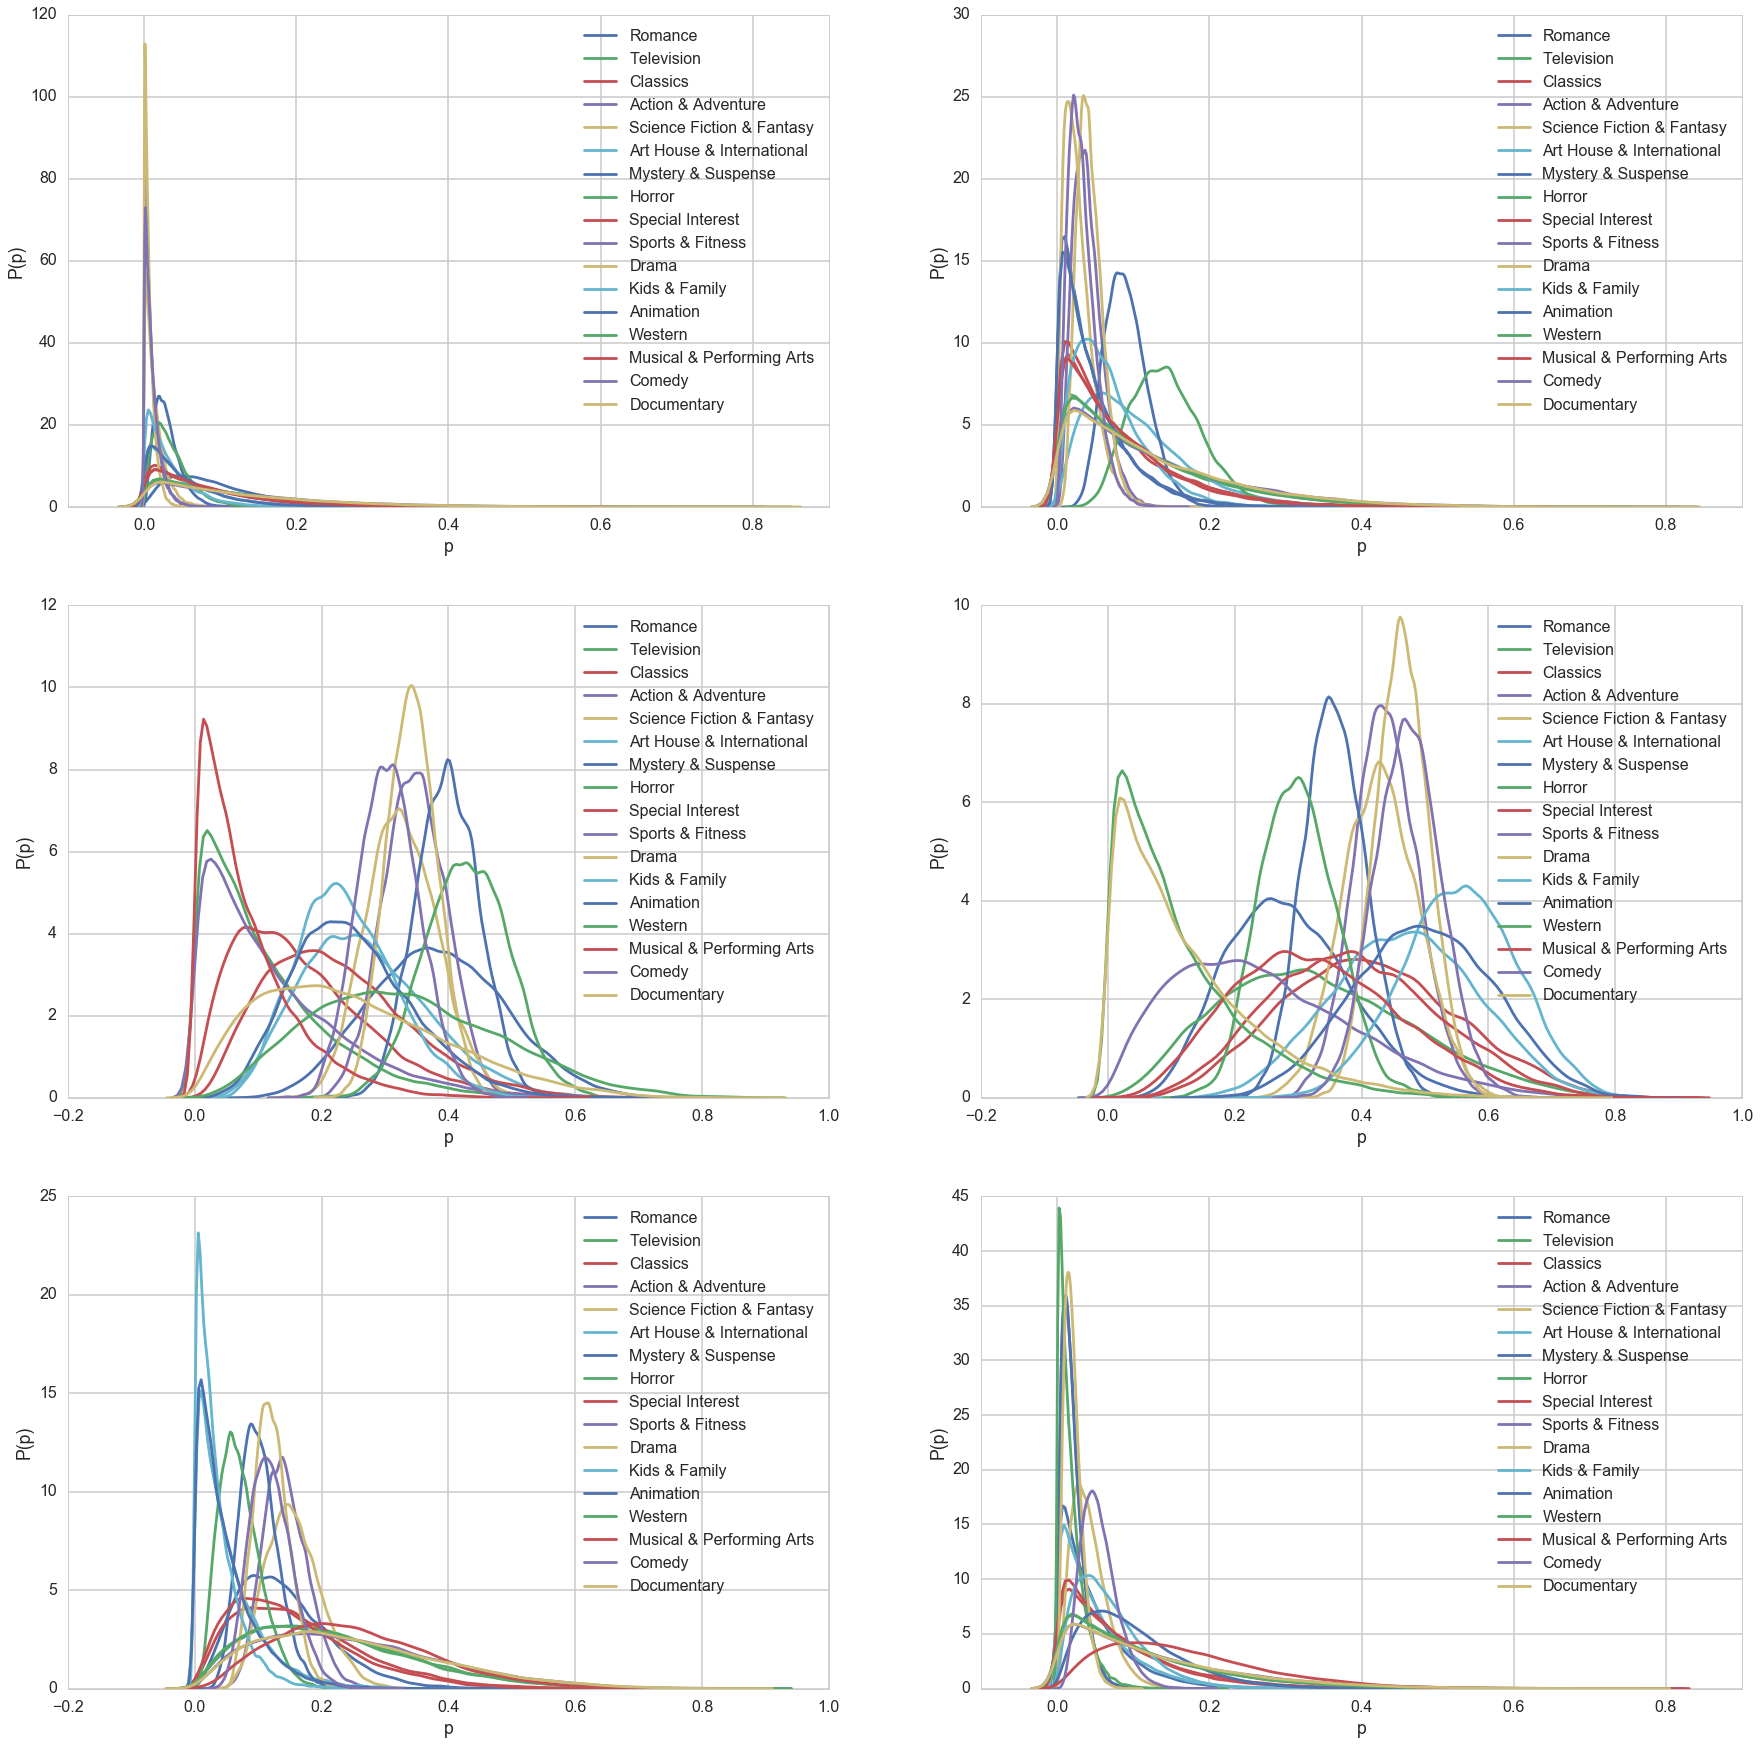

In [25]:
## Comparing posterior distributions of p0,..p5 for all different genres
burnin = 10000
plt.figure(figsize=[30,30])
for pindx in range(6):
    fig = plt.subplot(3,2,pindx+1)
    for genreindx in range(numgenres):
        sns.kdeplot(alltraces[burnin:,pindx,genreindx],label=dict_keys[genreindx])
    plt.legend()
    plt.xlabel('p')
    plt.ylabel('P(p)')

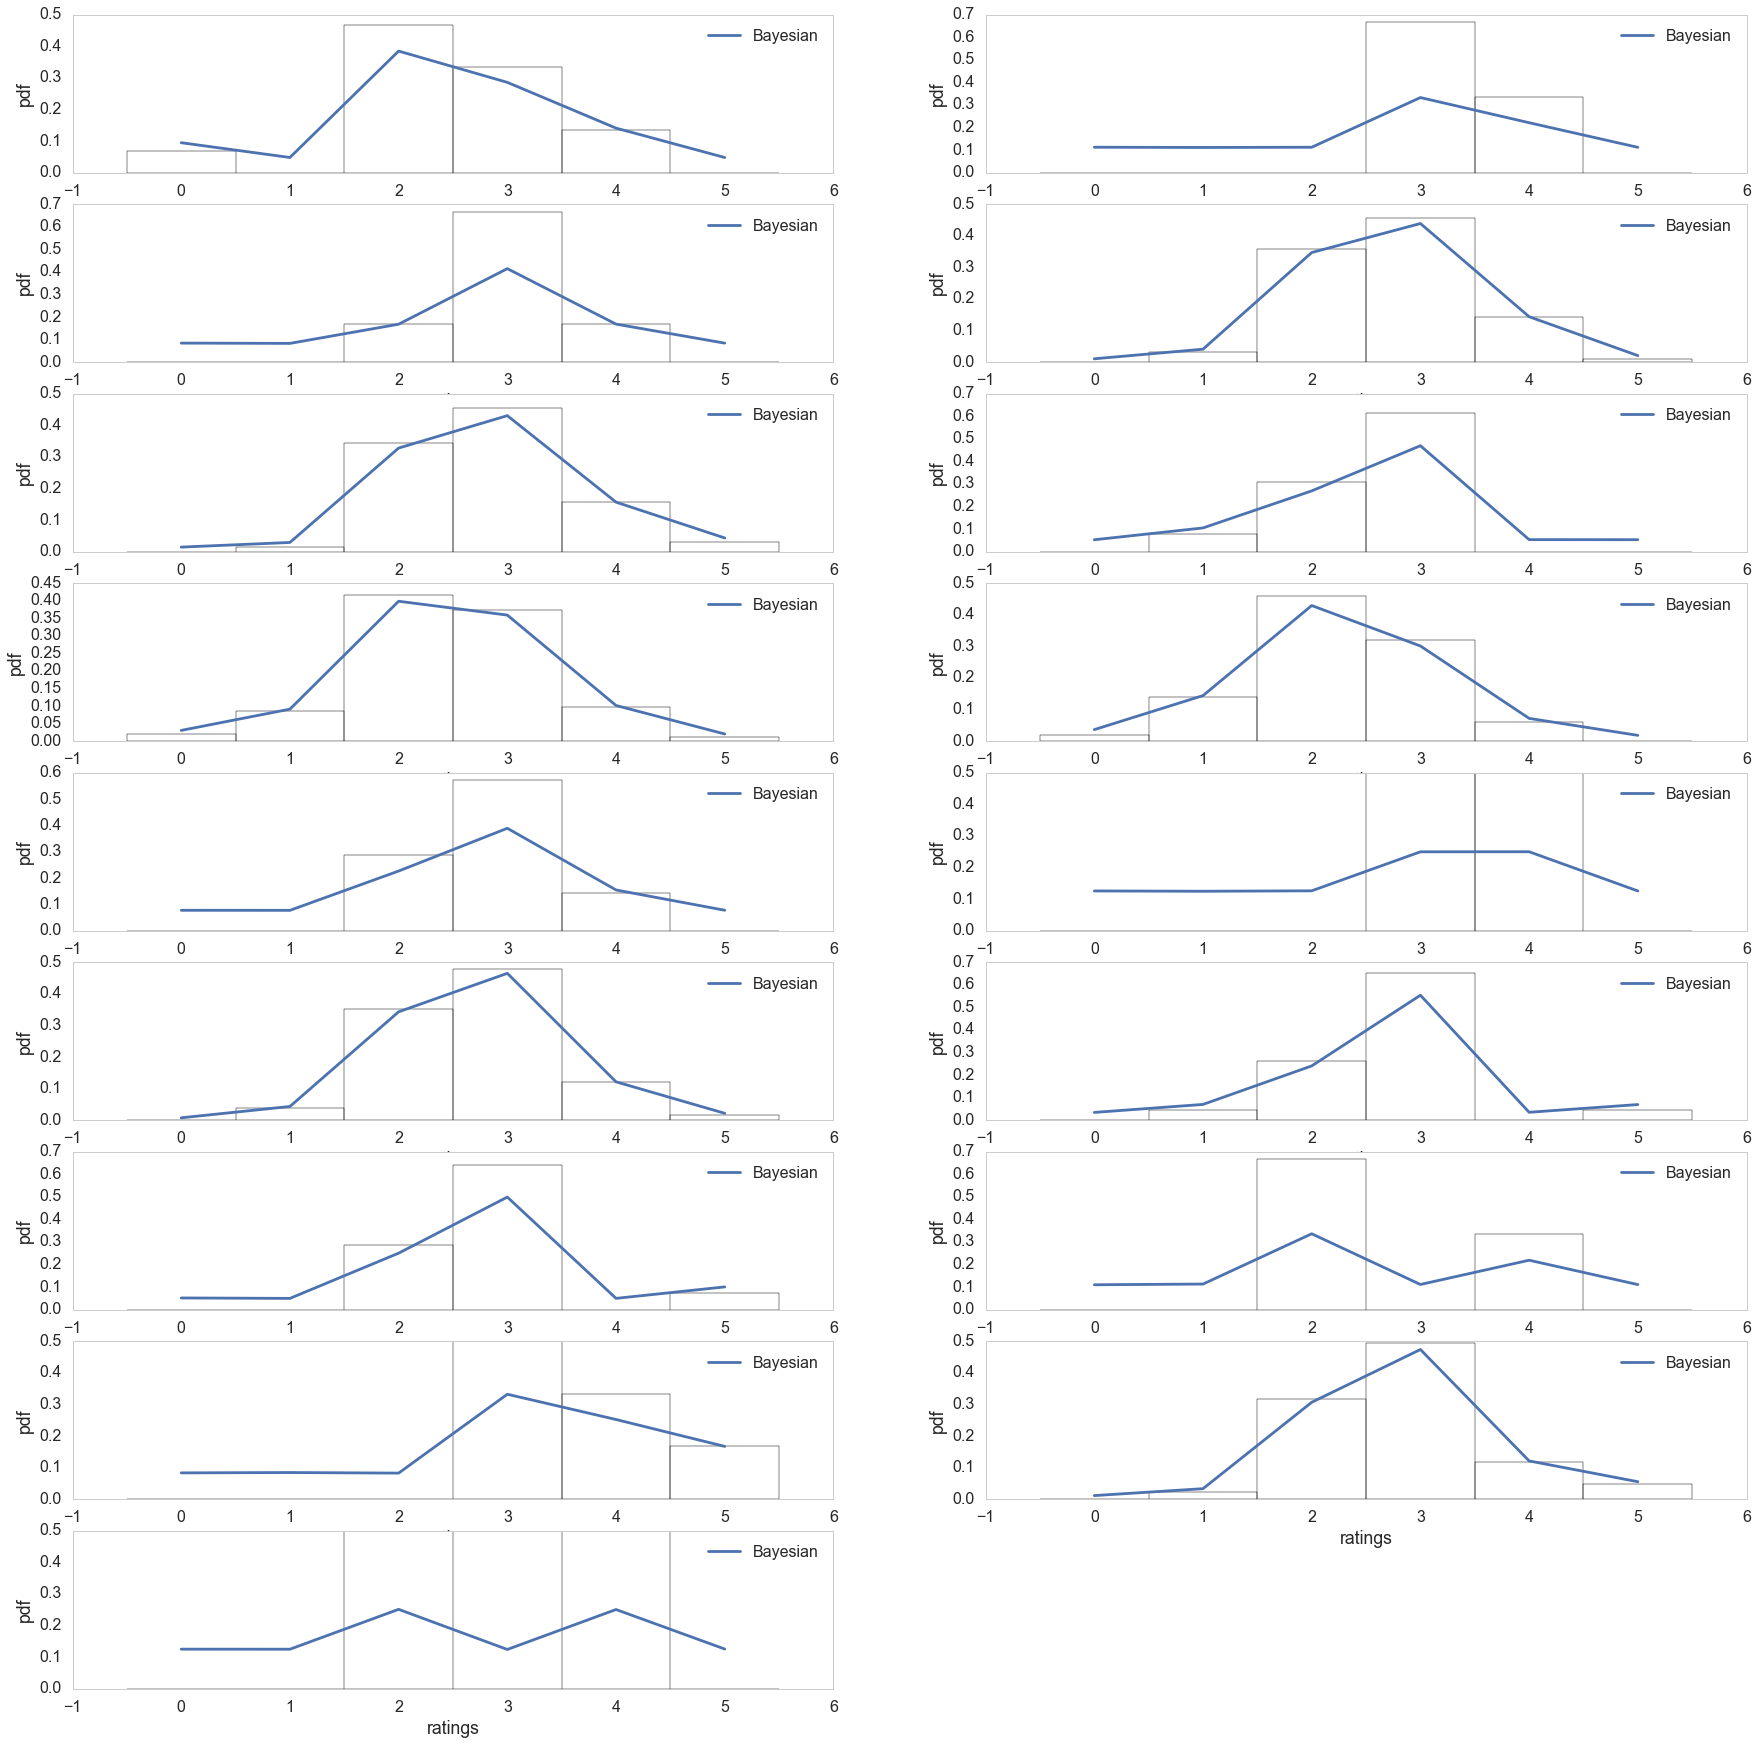

In [30]:
## Using posterior predictive to recover likely distribution of ratings (for a single movie in each category)
ratingsvec = np.arange(6)
Preconstructed = np.zeros((numgenres,len(ratingsvec)))
numsamples = len(alltraces[burnin:,1,1])
for genreindx in range(numgenres):
    psamples = alltraces[burnin:,:,genreindx]

    for ratingsindex in np.arange(0,len(ratingsvec)):
        rating = np.zeros(6)
        rating[ratingsindex] = 1.
        pplikelihood = []
        for sampleindx in range(numsamples):
            pplikelihood.append(Multinomial(psamples[sampleindx,:],rating))
        Preconstructed[genreindx,ratingsindex] = np.mean(pplikelihood)

## Plot posterior predictive likelihood over the raw data (for visual comparison)
plt.figure(figsize=[30,30])
for genreindx in range(numgenres):
    fig = plt.subplot(9,2,genreindx+1)
    plt.bar(ratingsvec,rating_dist[genreindx]/np.sum(rating_dist[genreindx]),width=1, align="center",fill=False)
    #plt.plot(tvec,Pvec,label = "Poisson (analytic)")
    plt.plot(ratingsvec,Preconstructed[genreindx],label="Bayesian")
    plt.xlabel("ratings")
    plt.ylabel("pdf")
    plt.legend()
    plt.grid()    

In [44]:
## Calculate average rating from posterior predictive and rank the different genres
## Check the sum of posterior predictive likelihood:
sumPP = np.sum(Preconstructed,1)

## Using posterior predictive to find weighted average rating for the different genres
avrating_PP = Preconstructed[:,1]*1 + Preconstructed[:,2]*2 + Preconstructed[:,3]*3 + Preconstructed[:,4]*4 + Preconstructed[:,5]*5

sortedavrating = np.sort(avrating_PP)[::-1]
sortedindices = np.argsort(avrating_PP)[::-1]
sortedgenres = []
for genreindx in range(numgenres):
    sortedgenres.append(dict_keys[sortedindices[genreindx]])

print "average rating based on posterior predictive:", avrating_PP
print "Movie genre rankings (in order of preference):", sortedgenres

average rating based on posterior predictive: [ 2.47279681  2.77344946  2.750795    2.72559199  2.81496201  2.52321891
  2.47036598  2.28238874  2.69779076  2.74941767  2.7135469   2.69161671
  2.74682681  2.5481634   3.08622014  2.82520181  2.62600016]
Movie genre rankings (in order of preference): [u'Musical & Performing Arts', u'Comedy', u'Science Fiction & Fantasy', u'Television', u'Classics', u'Sports & Fitness', u'Animation', u'Action & Adventure', u'Drama', u'Special Interest', u'Kids & Family', u'Documentary', u'Western', u'Art House & International', u'Romance', u'Mystery & Suspense', u'Horror']
